### Import libraries

In [1]:
import re
import string
import nltk
import numpy as np
import pandas as pd
# nltk.download()
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold

import warnings
warnings.filterwarnings("ignore")

### Read data

In [5]:
# There are 3 different txt data so we will read them separately and concatenate them
df = pd.read_csv("/content/reviews_data.csv")
df

,text,label
0,way plug u unless go converter,0
1,good case excellent value,1
2,great jawbone,1
3,tied charger conversation lasting minutesmajor...,0
4,mic great,1
...,...,...
2743,think food flavor texture lacking,0
2744,appetite instantly gone,0
2745,overall impressed would go back,0
2746,whole experience underwhelming think well go n...,0


In [6]:
df.head()

,text,label
0,way plug u unless go converter,0
1,good case excellent value,1
2,great jawbone,1
3,tied charger conversation lasting minutesmajor...,0
4,mic great,1


In [7]:
# we can see that the dataset is balanced
df.label.value_counts()

1    1386
0    1362
Name: label, dtype: int64

### Data CLeaning and Preprocessing

In [22]:
# We first have to clean the text data
nltk.download('stopwords')
nltk.download('wordnet')
def clean_text(df, text_column):
    
    stop_words = nltk.corpus.stopwords.words('english')
    lemmatizer = nltk.stem.WordNetLemmatizer()
    df[text_column] = df[text_column].str.lower()  # convert to lowercase
    df[text_column] = df[text_column].fillna('')  # replace NaN values with empty string
    df[text_column] = df[text_column].apply(lambda x: re.sub(r'http\S+', '', x))  # remove URLs
    df[text_column] = df[text_column].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))  # remove punctuation
    df[text_column] = df[text_column].apply(lambda x: re.sub(r'\d+', '', x))  # remove numbers
    df[text_column] = df[text_column].apply(lambda x: re.sub(r'\s+', ' ', x.strip()))  # remove extra whitespaces
    df[text_column] = df[text_column].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    
    df[text_column] = df[text_column].apply(
    lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
    return df


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [23]:
cleaned_df = clean_text(df, 'text')

### Word CLoud

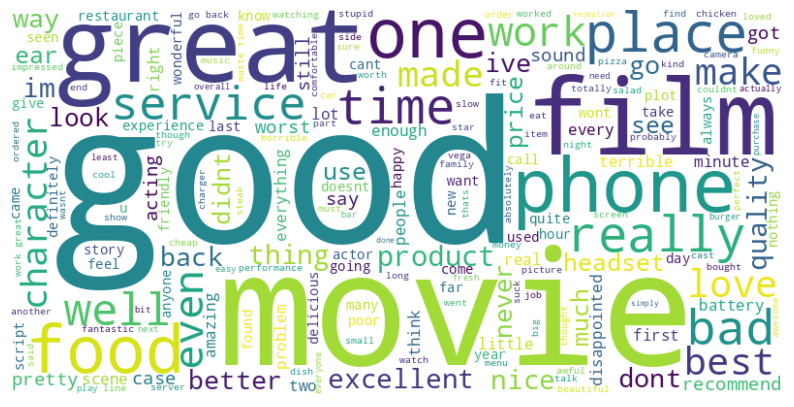

In [24]:

# Combine the text from all rows into a single string
text = ' '.join(cleaned_df['text'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Data Splitting

In [25]:
# split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(cleaned_df['text'], cleaned_df['label'], test_size=0.2)

In [26]:
# applt tf-idf to obtain embeddings
tf_idf = TfidfVectorizer()
x_train = tf_idf.fit_transform(x_train)
x_test = tf_idf.transform(x_test)

In [27]:
kfold = StratifiedKFold(n_splits=5, random_state = 42, shuffle = True)
scoring = {'Accuracy':'accuracy', 'Precision': 'precision', 'Recall':'recall', 'F1': 'f1_micro'}

### Utility functions

In [28]:
def plot_roc_ml(clf,x_test,y_test,model_name):
    # Plot roc curve
    y_pred = clf.predict(x_test)
    y_pred_proba = clf.predict_proba(x_test)
    y_scores = pd.DataFrame(y_pred_proba, columns=clf.classes_.tolist())[1].values
    auc_value = roc_auc_score(y_test, y_scores)
    print("AUC score: ",auc_value)

    fpr, tpr, thresholds = roc_curve(y_test, y_scores, pos_label=1.0)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', linewidth=2, label='ROC curve (area = %0.2f)' % auc_value)
    plt.plot([0, 1], [0, 1], color='navy', linewidth=2, linestyle='--')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC curve for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

In [29]:
def plot_roc_dl(y_test,y_pred_prob):
  # Compute the false positive rate (FPR), true positive rate (TPR), and thresholds
  fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

  # Compute the area under the ROC curve (AUC)
  roc_auc = auc(fpr, tpr)

  # Plot the ROC curve
  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], 'k--')  # Plot the random guessing curve
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc="lower right")
  plt.show()

In [30]:
def get_confusion_matrix_ml(clf,x_test,y_test):
    y_pred = clf.predict(x_test)

    # print classification metrics
    print(metrics.classification_report(y_test, y_pred, target_names=['Positive', 'Negative']))

    print("Confusion matrix:")
    cf_matrix = metrics.confusion_matrix(y_test, y_pred)
    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt='.2%', cmap='Blues')

In [31]:
def get_confusion_matrix_dl(y_test,y_pred):
    # print classification metrics
    print(metrics.classification_report(y_test, y_pred, target_names=['Positive', 'Negative']))

    print("Confusion matrix:")
    cf_matrix = metrics.confusion_matrix(y_test, y_pred)
    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt='.2%', cmap='Blues')

In [32]:
results = pd.DataFrame(columns=["Classifier", "Accuracy", "Precision", "Recall", "F1"])
accuracy, prec, rec, f1 = [], [], [], []

In [33]:
def fill_metrics_ml(clf):
    global accuracy, prec, rec, f1
    max_ind = np.nanargmax(clf_lr.cv_results_['mean_test_Accuracy'])
    accuracy.append(clf.cv_results_['mean_test_Accuracy'][max_ind])
    prec.append(clf.cv_results_['mean_test_Precision'][max_ind])
    rec.append(clf.cv_results_['mean_test_Recall'][max_ind])
    f1.append(clf.cv_results_['mean_test_F1'][max_ind])


In [34]:
def fill_metrics_dl(y_test,y_pred):
  
  global accuracy, prec, rec, f1
  # Calculate accuracy
  acc = accuracy_score(y_test, y_pred)

  # Calculate precision
  precision = precision_score(y_test, y_pred)

  # Calculate recall
  recall = recall_score(y_test, y_pred)

  # Calculate F1-score
  f1_sc = f1_score(y_test, y_pred)
  accuracy.append(acc)
  prec.append(precision)
  rec.append(recall)
  f1.append(f1_sc)


### Logistic Regression

In [35]:
lr = LogisticRegression()
params = {
    "penalty": ("l1", "l2"),
    "tol": (0.1, 0.01, 0.001, 0.0001),
    "C": (10.0, 1.0, 0.1, 0.01)
}
clf_lr = GridSearchCV(lr, params, cv = kfold, scoring=scoring, refit='Accuracy')
clf_lr.fit(x_train, y_train)
print("Best score: ",clf_lr.best_score_)

Best score:  0.7838972872230275


In [36]:
fill_metrics_ml(clf_lr)

              precision    recall  f1-score   support

    Positive       0.83      0.82      0.82       277
    Negative       0.82      0.82      0.82       273

    accuracy                           0.82       550
   macro avg       0.82      0.82      0.82       550
weighted avg       0.82      0.82      0.82       550

Confusion matrix:


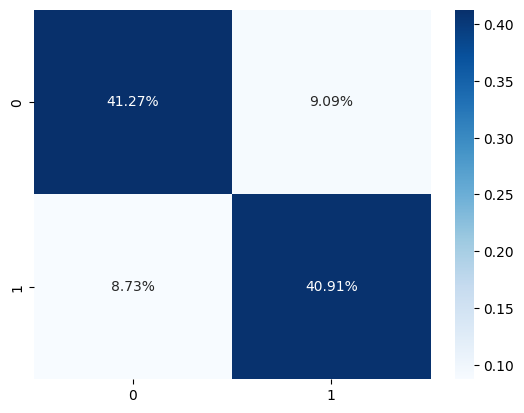

In [37]:
get_confusion_matrix_ml(clf_lr.best_estimator_,x_test,y_test)

AUC score:  0.9041536081247273


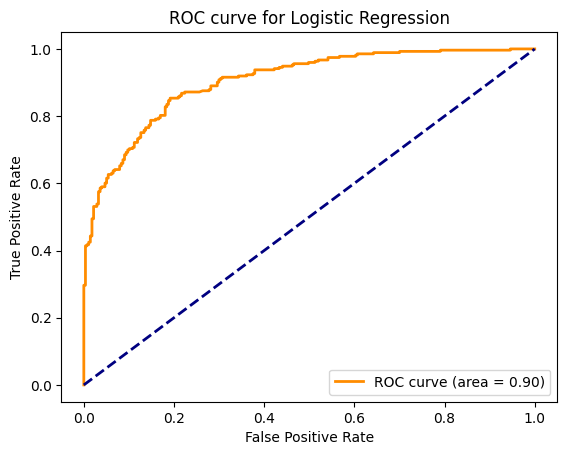

In [38]:
plot_roc_ml(clf_lr.best_estimator_,x_test,y_test,'Logistic Regression')

### Naiver Bayes

In [39]:
nb = MultinomialNB()
params = {
    "alpha":[0.25, 0.5, 1, 1.25, 1.5, 2, 4, 8],
    "fit_prior":[True, False]
}
clf_nb = GridSearchCV(nb, params, cv = kfold, scoring=scoring, refit='Accuracy')
clf_nb.fit(x_train, y_train)
print("Best score: ",clf_nb.best_score_)

Best score:  0.7807175398633258


In [40]:
fill_metrics_ml(clf_nb)

              precision    recall  f1-score   support

    Positive       0.82      0.79      0.80       277
    Negative       0.79      0.83      0.81       273

    accuracy                           0.81       550
   macro avg       0.81      0.81      0.81       550
weighted avg       0.81      0.81      0.81       550

Confusion matrix:


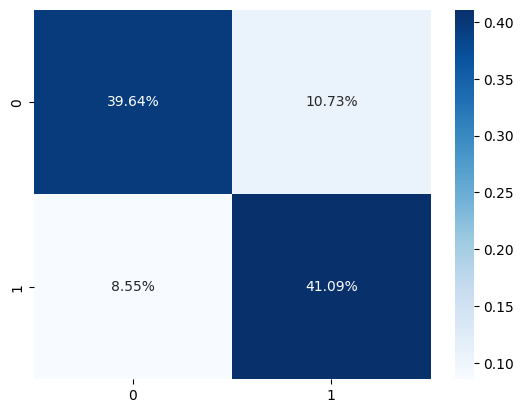

In [41]:
get_confusion_matrix_ml(clf_nb.best_estimator_,x_test,y_test)

AUC score:  0.8950423824070033


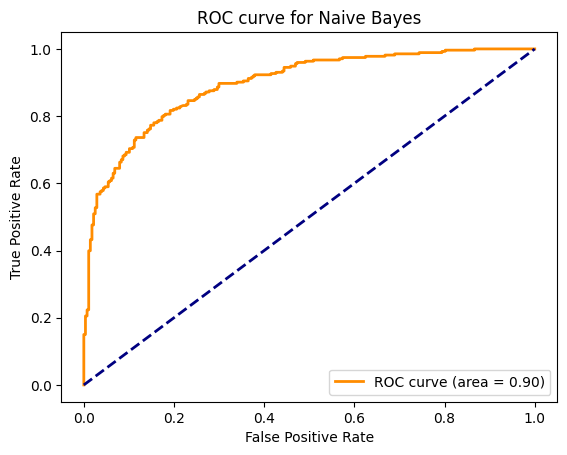

In [42]:
plot_roc_ml(clf_nb.best_estimator_,x_test,y_test,'Naive Bayes')

### SVM

In [43]:
svm = SVC(probability=True)
params = {'kernel': ['rbf'], 
          'gamma': [ 0.001, 0.01, 0.1, 1],
          'C': [1, 10, 50, 100, 200, 300]}
clf_svm = GridSearchCV(svm, params, cv = kfold, scoring=scoring, refit='Accuracy')
clf_svm.fit(x_train, y_train)
print("Best score: ",clf_svm.best_score_)

Best score:  0.7925471112031477


In [44]:
fill_metrics_ml(clf_svm)

              precision    recall  f1-score   support

    Positive       0.81      0.82      0.81       277
    Negative       0.81      0.80      0.81       273

    accuracy                           0.81       550
   macro avg       0.81      0.81      0.81       550
weighted avg       0.81      0.81      0.81       550

Confusion matrix:


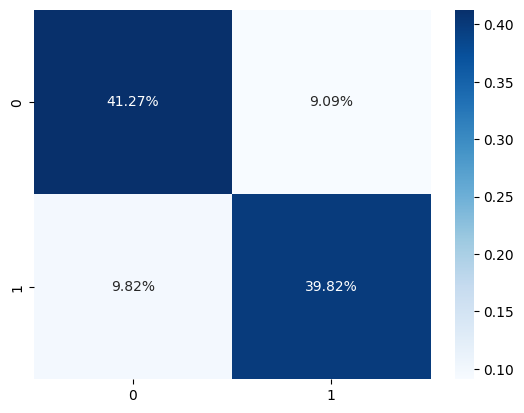

In [45]:
get_confusion_matrix_ml(clf_svm.best_estimator_,x_test,y_test)

AUC score:  0.8918025416220363


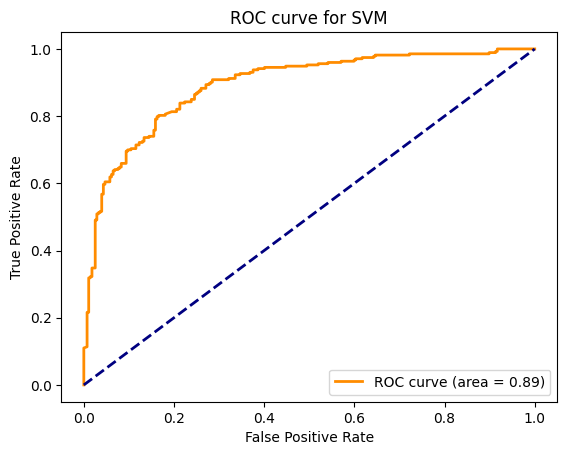

In [46]:
plot_roc_ml(clf_svm.best_estimator_,x_test,y_test,'SVM')

# LSTM MODEL

In [50]:

# Concatenate the datasets
data = pd.read_csv('/content/reviews_data.csv')

reviews = data['text']
labels = data['label']

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(reviews, labels, test_size=0.2, random_state=42)

# Handle NaN values
x_test = x_test.fillna('')  # Replace NaN with empty string

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

# Convert text to sequences
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

# Pad sequences
max_len = 100  # Maximum sequence length
x_train_pad = pad_sequences(x_train_seq, maxlen=max_len, padding='post')
x_test_pad = pad_sequences(x_test_seq, maxlen=max_len, padding='post')

# Define the LSTM model
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, 128, input_length=max_len))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(x_train_pad, y_train, epochs=50, batch_size=32, validation_data=(x_test_pad, y_test))

# Evaluate the model
loss, accuracy_lstm = model.evaluate(x_test_pad, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy_lstm)

# Generate predictions
y_pred_prob = model.predict(x_test_pad)
y_pred = np.where(y_pred_prob > 0.5, 1, 0)

Epoch 1/50
69/69 [==============================] - 19s 169ms/step - loss: 0.6939 - accuracy: 0.5018 - val_loss: 0.6965 - val_accuracy: 0.4709
Epoch 2/50
69/69 [==============================] - 6s 81ms/step - loss: 0.6935 - accuracy: 0.5141 - val_loss: 0.6939 - val_accuracy: 0.4709
Epoch 3/50
69/69 [==============================] - 5s 77ms/step - loss: 0.6933 - accuracy: 0.5014 - val_loss: 0.6960 - val_accuracy: 0.4709
Epoch 4/50
69/69 [==============================] - 2s 32ms/step - loss: 0.6937 - accuracy: 0.5050 - val_loss: 0.6937 - val_accuracy: 0.4709
Epoch 5/50
69/69 [==============================] - 2s 34ms/step - loss: 0.6933 - accuracy: 0.5141 - val_loss: 0.6939 - val_accuracy: 0.4709
Epoch 6/50
69/69 [==============================] - 2s 35ms/step - loss: 0.6930 - accuracy: 0.5141 - val_loss: 0.6943 - val_accuracy: 0.4709
Epoch 7/50
69/69 [==============================] - 1s 18ms/step - loss: 0.6925 - accuracy: 0.5141 - val_loss: 0.6942 - val_accuracy: 0.4709
Epoch 8/50


In [52]:
fill_metrics_dl(y_test, y_pred)

              precision    recall  f1-score   support

    Positive       0.00      0.00      0.00       291
    Negative       0.47      1.00      0.64       259

    accuracy                           0.47       550
   macro avg       0.24      0.50      0.32       550
weighted avg       0.22      0.47      0.30       550

Confusion matrix:


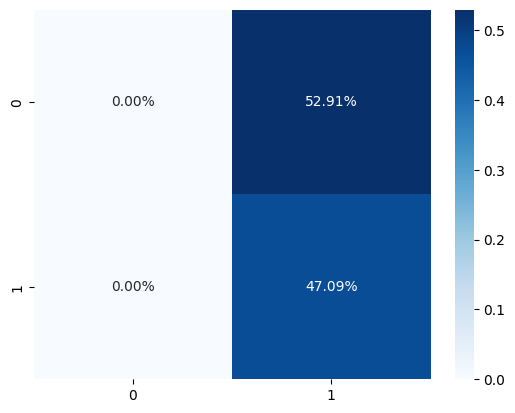

In [53]:
get_confusion_matrix_dl(y_test, y_pred)

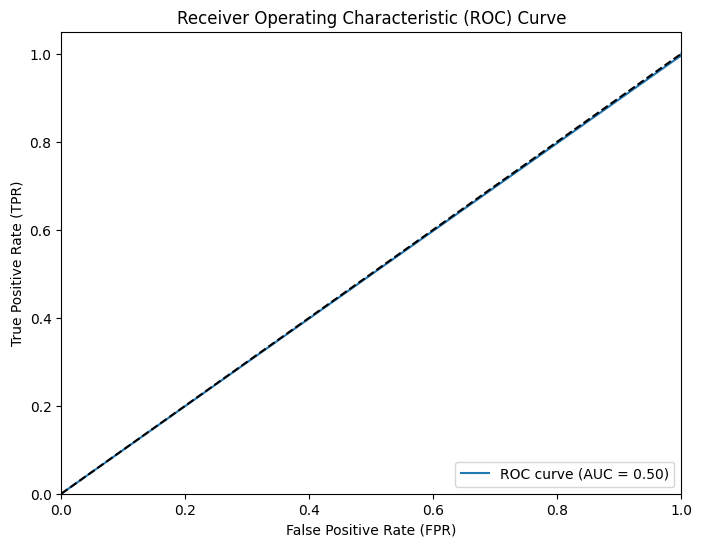

In [51]:
plot_roc_dl(y_test,y_pred_prob)

# CNN

In [54]:
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, 128, input_length=max_len))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

# Compile the model`
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(x_train_pad, y_train, epochs=50, batch_size=32, validation_data=(x_test_pad, y_test))

loss, accuracy_cnn = model.evaluate(x_test_pad, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy_cnn)
# Generate predictions
y_pred_prob = model.predict(x_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int)


Epoch 1/50
69/69 [==============================] - 14s 116ms/step - loss: 0.6656 - accuracy: 0.5878 - val_loss: 0.5885 - val_accuracy: 0.7655
Epoch 2/50
69/69 [==============================] - 5s 65ms/step - loss: 0.3883 - accuracy: 0.8740 - val_loss: 0.4292 - val_accuracy: 0.8036
Epoch 3/50
69/69 [==============================] - 3s 44ms/step - loss: 0.1599 - accuracy: 0.9463 - val_loss: 0.5046 - val_accuracy: 0.7982
Epoch 4/50
69/69 [==============================] - 2s 32ms/step - loss: 0.0779 - accuracy: 0.9750 - val_loss: 0.5998 - val_accuracy: 0.7800
Epoch 5/50
69/69 [==============================] - 1s 20ms/step - loss: 0.0477 - accuracy: 0.9877 - val_loss: 0.6520 - val_accuracy: 0.7764
Epoch 6/50
69/69 [==============================] - 1s 21ms/step - loss: 0.0340 - accuracy: 0.9877 - val_loss: 0.7269 - val_accuracy: 0.7909
Epoch 7/50
69/69 [==============================] - 1s 22ms/step - loss: 0.0256 - accuracy: 0.9904 - val_loss: 0.7987 - val_accuracy: 0.7800
Epoch 8/50


In [55]:
fill_metrics_dl(y_test, y_pred)

              precision    recall  f1-score   support

    Positive       0.80      0.73      0.76       291
    Negative       0.72      0.80      0.76       259

    accuracy                           0.76       550
   macro avg       0.76      0.76      0.76       550
weighted avg       0.76      0.76      0.76       550

Confusion matrix:


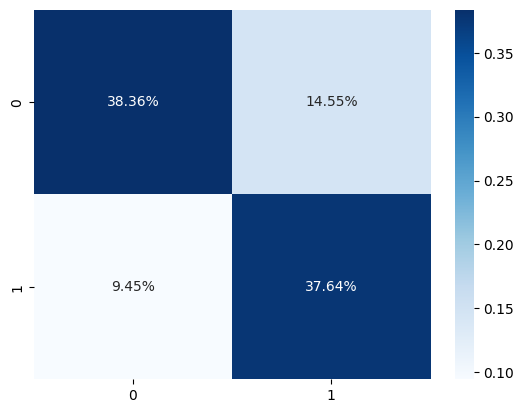

In [56]:
get_confusion_matrix_dl(y_test, y_pred)

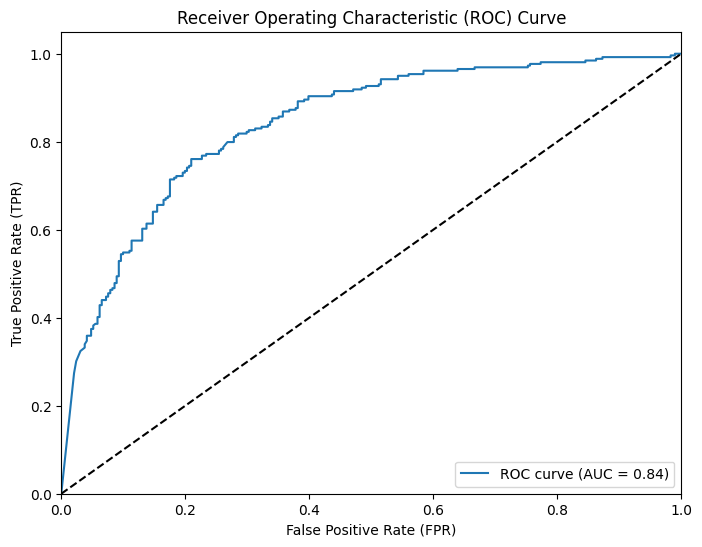

In [57]:
plot_roc_dl(y_test,y_pred_prob)

### Contingency table

In [58]:
results['Classifier'] = ['LR', 'NB', 'SVM', 'LSTM','CNN']
results['Accuracy'] = accuracy
results['Precision'] = prec
results['Recall'] = rec
results['F1'] = f1


In [59]:
results

,Classifier,Accuracy,Precision,Recall,F1
0,LR,0.783897,0.790804,0.778960,0.783897
1,NB,0.771616,0.749528,0.824785,0.771616
2,SVM,0.506369,0.506369,1.000000,0.506369
3,LSTM,0.470909,0.470909,1.000000,0.640297
4,CNN,0.760000,0.721254,0.799228,0.758242


In [60]:
##Saving into csv file
results.to_csv("/content/results.csv", index=False)


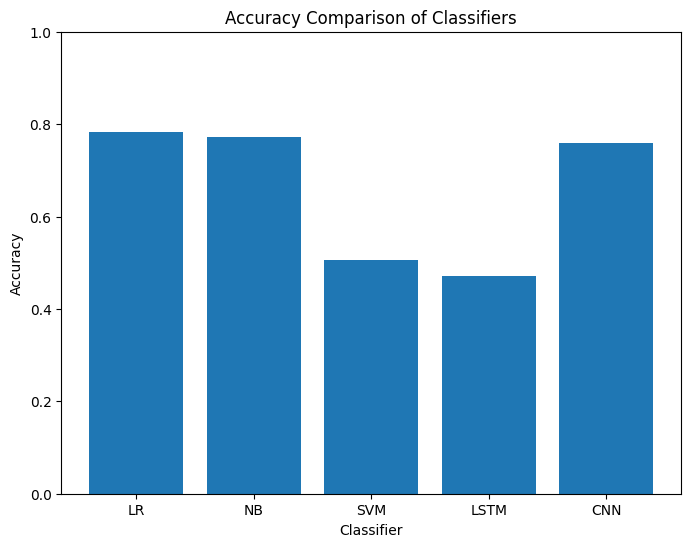

In [61]:
classifiers = results['Classifier']
accuracy_scores = results['Accuracy']

plt.figure(figsize=(8, 6))
plt.bar(classifiers, accuracy_scores)
plt.title('Accuracy Comparison of Classifiers')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.show()
